<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
##### Your Code Here #####
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(45)
tf.__version__

'1.14.0'

In [2]:
from tensorflow.keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data(path='boston_housing.npz', test_split=0.2, seed=47)
# X_train = train[0]
# y_train = train[1]
# X_test = test[0]
# y_test = test[1]

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))

In [4]:
X_train.shape

(404, 13)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


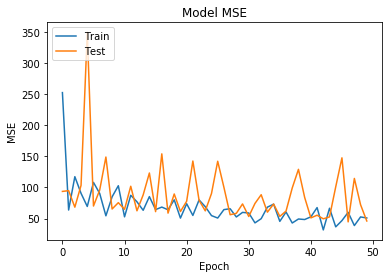

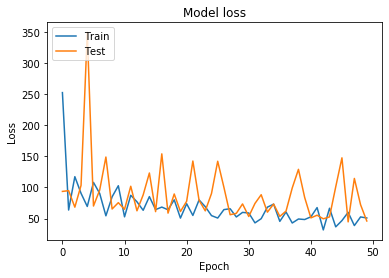

In [5]:
# model = Sequential()
inputs = Input(shape=(13,))#(784,))#X_train#(shape=X_train.shape))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss="mean_squared_error",
              metrics=['mse', 'mae'])
history = model.fit(X_train, y_train, validation_split=0.25, epochs=50, verbose=0)

# Plot training & validation accuracy values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
np.mean((y_test - model.predict(X_test))**2)

152.17372392272543

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(60000, -1).astype('float32')
X_test = X_test.reshape(10000, -1).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 784) y_train shape: (60000, 10)


In [8]:
inputs = Input(shape=(X_train.shape[1],))#(784,))#X_train#(shape=X_train.shape))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.25, epochs=10, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 7s 150us/sample - loss: 0.5211 - acc: 0.8111 - val_loss: 0.4893 - val_acc: 0.8313
Epoch 2/10
45000/45000 [==============================] - 7s 149us/sample - loss: 0.4071 - acc: 0.8574 - val_loss: 0.4937 - val_acc: 0.8079
Epoch 3/10
45000/45000 [==============================] - 7s 147us/sample - loss: 0.3824 - acc: 0.8696 - val_loss: 0.4117 - val_acc: 0.8658
Epoch 4/10
45000/45000 [==============================] - 7s 146us/sample - loss: 0.3643 - acc: 0.8746 - val_loss: 0.5454 - val_acc: 0.8411
Epoch 5/10
45000/45000 [==============================] - 7s 146us/sample - loss: 0.3579 - acc: 0.8778 - val_loss: 0.6197 - val_acc: 0.8333
Epoch 6/10
45000/45000 [==============================] - 7s 146us/sample - loss: 0.3512 - acc: 0.8807 - val_loss: 0.4278 - val_acc: 0.8543
Epoch 7/10
45000/45000 [==============================] - 7s 148us/sample - loss: 0.3403 - acc: 0.8843 - val_l

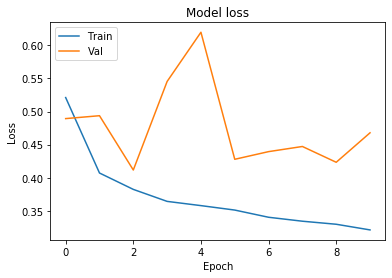

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8612


## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# X shape was (600, 28, 28) NHW, reshaping it to (600, 28, 28, 1) NHWC
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = X_train / 255
X_test = X_test / 255

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28, 1) y_train shape: (60000, 10)


In [13]:
inputs = Input(shape=X_train.shape[1:])#(784,))#X_train#(shape=X_train.shape))

# a layer instance is callable on a tensor, and returns a tensor
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.25, epochs=10, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 14s 313us/sample - loss: 0.5390 - acc: 0.8060 - val_loss: 0.3423 - val_acc: 0.8751
Epoch 2/10
45000/45000 [==============================] - 13s 279us/sample - loss: 0.3518 - acc: 0.8762 - val_loss: 0.3096 - val_acc: 0.8909
Epoch 3/10
45000/45000 [==============================] - 13s 281us/sample - loss: 0.3208 - acc: 0.8878 - val_loss: 0.3011 - val_acc: 0.8934
Epoch 4/10
45000/45000 [==============================] - 12s 276us/sample - loss: 0.3146 - acc: 0.8919 - val_loss: 0.2984 - val_acc: 0.8995
Epoch 5/10
45000/45000 [==============================] - 12s 275us/sample - loss: 0.3179 - acc: 0.8920 - val_loss: 0.3403 - val_acc: 0.8847
Epoch 6/10
45000/45000 [==============================] - 12s 277us/sample - loss: 0.3204 - acc: 0.8918 - val_loss: 0.2967 - val_acc: 0.9016
Epoch 7/10
45000/45000 [==============================] - 12s 276us/sample - loss: 0.3286 - acc: 0.8916 

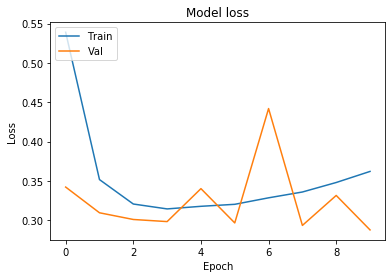

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        3692

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8902


In [17]:
60000*28*28/885326

53.13297022791605